**Classificação da qualidade da água**
 


* Station Code: Código único para cada lugar
* Locations: Nome do rio e para onde flui
* State: O estado em que o rio está fluindo
* Temp: Valor médio de temperatura
* DO: Valor médio de oxigênio dissolvido
* PH: Valor médio de pH
* Conductivity: Valor médio de condutividade
* BOD: Valor médio da demanda bioquímica de oxigênio
* NITRATE_N_NITRITE_N: Valor médio de nitrato-n e nitrito-n
* FECAL_COLIFORM: Valor médio de coliformes fecais
* TOTAL_COLIFORM: Valor médio de coliformes totais





In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import roc_curve, auc, confusion_matrix

In [ ]:
path="/content/waterquality.csv"
df =pd.read_csv(path,sep=',', engine='python')

In [ ]:
df.head()

,STATION CODE,LOCATIONS,STATE,TEMP,DO,pH,CONDUCTIVITY,BOD,NITRATE_N_NITRITE_N,FECAL_COLIFORM,TOTAL_COLIFORM
0,1312,"GODAVARI AT JAYAKWADI DAM, AURNAGABAD,MAHARASHTRA",MAHARASHTRA,29.2,6.4,8.1,735.0,3.4,2.00,3.0,73.0
1,2177,GODAVARI RIVER NEAR SOMESHWAR TEMPLE.,MAHARASHTRA,24.5,6.0,8.0,270.0,3.1,2.00,72.0,182.0
2,2182,GODAVARI RIVER AT SAIKHEDA.,MAHARASHTRA,25.8,5.5,7.8,355.0,4.2,9.00,59.0,133.0
3,2179,"GODAVARI RIVER AT HANUMAN GHAT, NASHIK CITY.",MAHARASHTRA,24.8,5.5,7.8,371.0,5.6,3.55,90.0,283.0
4,2183,GODAVARI RIVER AT NANDUR- MADMESHWAR DAM.,MAHARASHTRA,25.7,5.7,7.9,294.0,3.2,2.69,45.0,132.0


# Pré-processamento

## Tratamento dos dados faltantes

In [ ]:
df =df.drop(['STATION CODE', 'LOCATIONS','STATE'], axis=1)

In [ ]:
X_columns = ['TEMP', 'DO', 'pH', 'CONDUCTIVITY', 'BOD', 'NITRATE_N_NITRITE_N',
       'FECAL_COLIFORM', 'TOTAL_COLIFORM']


In [ ]:
df.isnull().sum()

TEMP                    5
DO                      2
pH                      0
CONDUCTIVITY           30
BOD                     6
NITRATE_N_NITRITE_N     2
FECAL_COLIFORM         82
TOTAL_COLIFORM         39
dtype: int64

In [ ]:
df['TEMP'].fillna(df['TEMP'].mean(), inplace = True)
df['DO'].fillna(df['DO'].mean(), inplace = True)
df['CONDUCTIVITY'].fillna(df['CONDUCTIVITY'].mean(), inplace = True)
df['BOD'].fillna(df['BOD'].mean(), inplace = True)
df['NITRATE_N_NITRITE_N'].fillna(df['NITRATE_N_NITRITE_N'].mean(), inplace = True)
df['FECAL_COLIFORM'].fillna(df['FECAL_COLIFORM'].mean(), inplace = True)
df['TOTAL_COLIFORM'].fillna(df['TOTAL_COLIFORM'].mean(), inplace = True)

In [ ]:
df.isnull().sum()

TEMP                   0
DO                     0
pH                     0
CONDUCTIVITY           0
BOD                    0
NITRATE_N_NITRITE_N    0
FECAL_COLIFORM         0
TOTAL_COLIFORM         0
dtype: int64

## Adicionando as classes

A água pode ser classificada em termos do valor médio do oxigênio dissolvido


*  Classe 1, <3 - letal
*  Classe 2, [3,5] - condições de estresse
*  Classe 3, >5 condições mínimas




In [ ]:
df['classe'] = df['DO']
df['classe'].loc[df['DO'] <3] = 1
df['classe'].loc[(df['DO'] >=3) & (df['DO'] <5)] = 2
df['classe'].loc[df['DO'] >=5] = 3
df

,TEMP,DO,pH,CONDUCTIVITY,BOD,NITRATE_N_NITRITE_N,FECAL_COLIFORM,TOTAL_COLIFORM,classe
0,29.2,6.4,8.1,735.0,3.4,2.00,3.0,73.0,3.0
1,24.5,6.0,8.0,270.0,3.1,2.00,72.0,182.0,3.0
2,25.8,5.5,7.8,355.0,4.2,9.00,59.0,133.0,3.0
3,24.8,5.5,7.8,371.0,5.6,3.55,90.0,283.0,3.0
4,25.7,5.7,7.9,294.0,3.2,2.69,45.0,132.0,3.0
...,...,...,...,...,...,...,...,...,...
529,23.2,4.4,8.1,538.0,1.2,1.00,5.0,14.0,2.0
530,22.9,5.6,8.4,591.0,1.1,3.00,4.0,8.0,3.0
531,22.9,5.8,8.5,588.0,1.2,3.00,4.0,6.0,3.0
532,28.7,4.1,7.9,1133.0,2.3,2.00,7.0,67.0,2.0


In [ ]:
X_columns = ['TEMP', 'pH', 'CONDUCTIVITY', 'BOD', 'NITRATE_N_NITRITE_N',
       'FECAL_COLIFORM', 'TOTAL_COLIFORM']

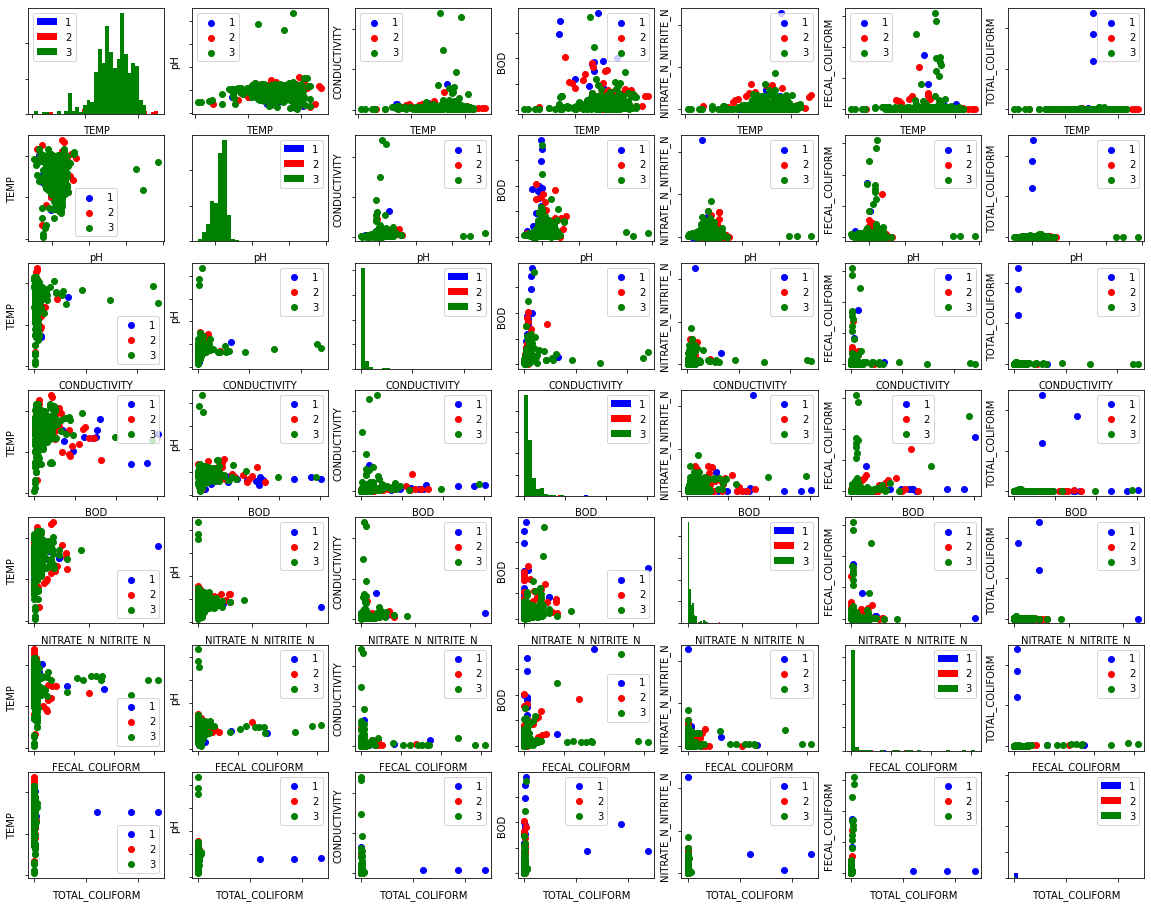

In [ ]:
fig, axs = plt.subplots(7,7,figsize=(20, 16))
for i in range(0,7):
    for j in range(0,7): 
        if(X_columns[i]==X_columns[j]):
            axs[i, j].hist(df[df["classe"] == 1][X_columns[j]],label='1',bins=30,color='blue')
            axs[i, j].hist(df[df["classe"] == 2][X_columns[j]],label='2',bins=30,color='red')
            axs[i, j].hist(df[df["classe"] == 3][X_columns[j]],label='3',bins=30,color='green')
            axs[i, j].set(xlabel=X_columns[i]) 
            axs[i,j].set_xticklabels([])
            axs[i,j].set_yticklabels([])
            axs[i, j].legend()
        else:
            
            axs[i, j].scatter(df[df["classe"] == 1][X_columns[i]],df[df["classe"] == 1][X_columns[j]],label='1',color='blue')
            axs[i, j].scatter(df[df["classe"] == 2][X_columns[i]],df[df["classe"] == 2][X_columns[j]],label='2',color='red')
            axs[i, j].scatter(df[df["classe"] == 3][X_columns[i]],df[df["classe"] == 3][X_columns[j]],label='3',color='green')
            axs[i, j].set(xlabel=X_columns[i], ylabel=X_columns[j]) 
            axs[i,j].set_xticklabels([])
            axs[i,j].set_yticklabels([])
            axs[i, j].legend()
plt.savefig('scatter.png')

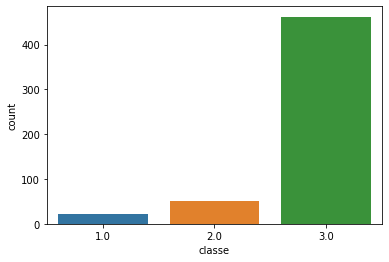

In [ ]:
sns.countplot(x = df['classe']);
plt.savefig('classesdesbalanceadas.pdf')

## Relanceando as classes

In [ ]:
!pip install imblearn

In [ ]:
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



In [ ]:
df =df.drop(['DO'], axis=1)

In [ ]:
X = df.drop("classe", axis = 1)
y = df['classe']

In [ ]:
smt = SMOTE()

In [ ]:
X, y = smt.fit_sample(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



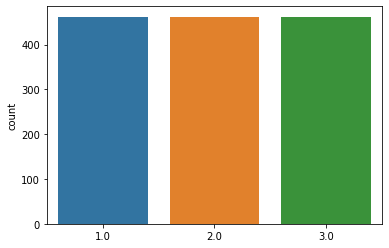

In [ ]:
ax = sns.countplot(x=y)

## Escalonando os dados

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Classificação

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

## LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
LDA = LinearDiscriminantAnalysis()
LDA.fit(X, y)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [ ]:
acc = []

In [ ]:
acc.append(100*LDA.score(X_test,y_test))
100*LDA.score(X_test,y_test)

66.18705035971223

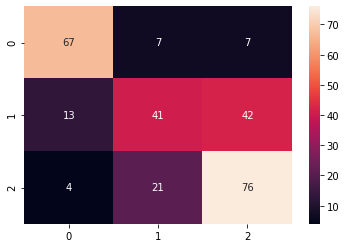

In [ ]:
y_pred_LDA = LDA.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred_LDA)
sns.heatmap(cf_matrix, annot=True)
plt.savefig('clda.pdf')

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
kdoknn = []
desempenhodoknn = []
def scorek(N):
  knn = KNeighborsClassifier(n_neighbors=N)
  knn.fit(X_train, y_train)
  return 100*knn.score(X_test, y_test)
for i in range(1,20):
  desempenhodoknn.append(scorek(i))
  kdoknn.append(i)

In [ ]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
def knnscore(k):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
  score_train = cross_val_score(knn, X_train, y_train,scoring = 'accuracy',cv=cv, n_jobs=-1)
  score_train = score_train.mean()
  score_test = cross_val_score(knn, X_test, y_test,scoring = 'accuracy',cv=cv, n_jobs=-1)
  score_test = score_test.mean()
  return score_train,score_test
scores_train = []
scores_test = []
k = []
for i in range(1,60):
  scores_train.append(knnscore(i)[0])
  scores_test.append(knnscore(i)[1])
  k.append(i)

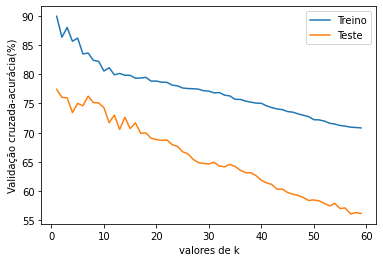

In [ ]:
plt.plot(np.array(k),100*np.array(scores_train),label='Treino')
plt.plot(np.array(k),100*np.array(scores_test),label='Teste')
plt.xlabel('valores de k')
plt.ylabel('Validação cruzada-acurácia(%)')
plt.legend()
plt.savefig('knn.pdf')

In [ ]:
scores_test.index(max(scores_test))
k[scores_test.index(max(scores_test))]

1

In [ ]:
acc.append(100*max(scores_test))
max(scores_test)

0.7740740740740741

In [ ]:
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors = k[scores_test.index(max(scores_test))]) 
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

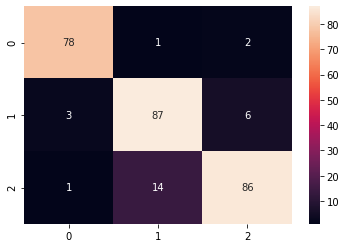

In [ ]:
y_pred_knn = knn.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cf_matrix, annot=True)
plt.savefig('cknn.pdf')

## SVM

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
SVM = make_pipeline(StandardScaler(), SVC(gamma='auto'))
SVM.fit(X, y)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='auto', kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [ ]:
acc.append(100*SVM.score(X_test,y_test))
100*SVM.score(X_test,y_test)

80.57553956834532

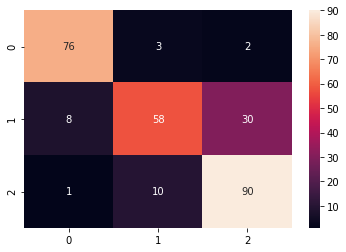

In [ ]:
y_pred_SVM = SVM.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred_SVM)
sns.heatmap(cf_matrix, annot=True)
plt.savefig('csvm.pdf')

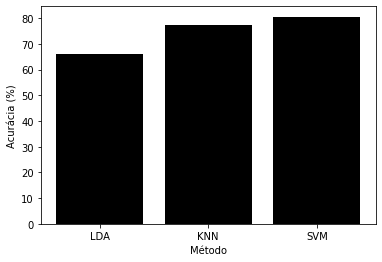

In [ ]:
plt.bar([1,2,3],acc,color='black')
plt.xticks([1,2,3],['LDA','KNN','SVM'])
plt.ylabel('Acurácia (%)')
plt.xlabel('Método')
plt.savefig('metodos.pdf')

## ROC

In [ ]:
from sklearn.metrics import roc_curve, auc

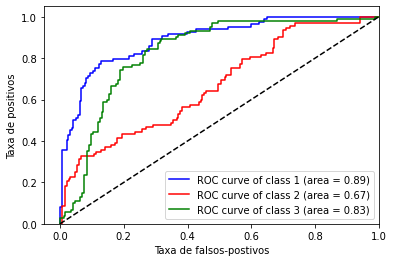

In [ ]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier

iris = datasets.load_iris()
X =X
y =y

# Binarize the output
y = label_binarize(y, classes=[1, 2, 3])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

classifier = OneVsRestClassifier(LDA)
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors=['blue','red','green']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i],
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', )
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de falsos-postivos')
plt.ylabel('Taxa de positivos')
plt.legend(loc="lower right")

plt.savefig('rlda.pdf')

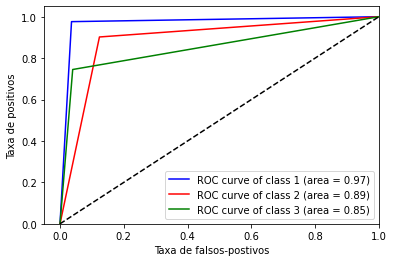

In [ ]:

y = label_binarize(y, classes=[1, 2, 3])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

classifier = OneVsRestClassifier(knn)
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors=['blue','red','green']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i],
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', )
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de falsos-postivos')
plt.ylabel('Taxa de positivos')
plt.legend(loc="lower right")

plt.savefig('rknn.pdf')

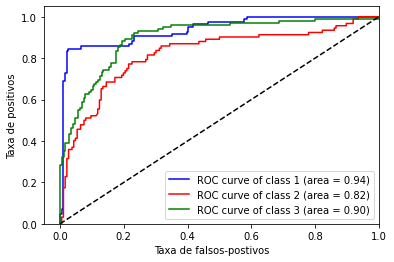

In [ ]:

y = label_binarize(y, classes=[1, 2, 3])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)
SVM =  SVC(gamma='auto', probability=True)
classifier = OneVsRestClassifier(SVM)
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors=['blue','red','green']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i],
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', )
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de falsos-postivos')
plt.ylabel('Taxa de positivos')
plt.legend(loc="lower right")

plt.savefig('rsvm.pdf')